Импортируем необходимые библиотеки

In [1]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import statsmodels.tsa.api as smt

In [2]:
def generate_by_template(template, serise_count = 10, make_noise = True, ot = -5, to = 5, count = 100):
    offs = np.random.rand(serise_count)
    arr = np.linspace(ot, to, count)
    result = []
    for i in range(serise_count):
        if make_noise:
            result.append(template(arr+offs[i])+np.random.normal(size = 100, scale= 0.1))
        else:
            result.append(template(arr+offs[i]))
    return result

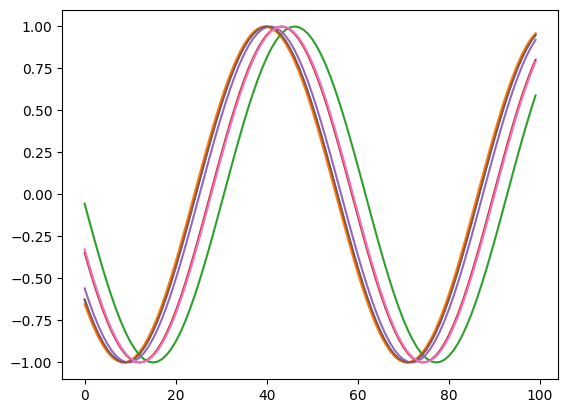

In [3]:
class1 = generate_by_template(np.cos, 7, False, count = 100)
class2 = generate_by_template(np.sin, 7, False, count = 100)
class3 = generate_by_template(np.tanh, 7, False, count = 100)
for ts in class1:
    plt.plot(ts)

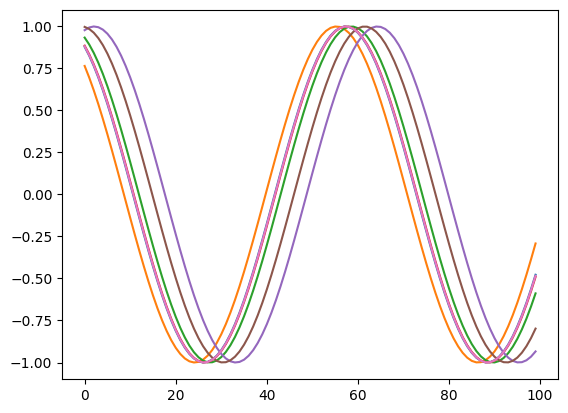

In [4]:
for ts in class2:
    plt.plot(ts)

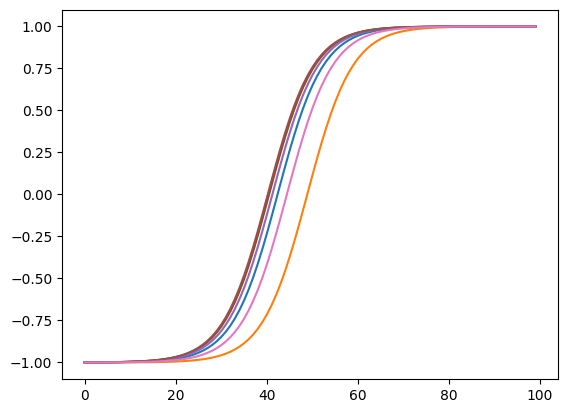

In [5]:
for ts in class3:
    plt.plot(ts)

## DTW

In [6]:
def distance_matrix(x, y, q) -> np.array:
    """
    Функция  рассчета  матрицы  расстояний между точками двух рядов 
    """
    mdist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            mdist[i,j] = np.abs((x[j]-y[i]))**q
    return mdist

In [7]:
# Посчитаем DTW для двух временных рядов
# Сначала напишем функцию, которая это все вычисляет


def DTW(x, x_s, q=1, isDTW=True):
    '''
        x: первый ряд
        x_s : второй ряд
        q : степень для вычисления базового расстояния
    '''
    N = len(x) # Считаем, что ряды равной длины. Но это не всегда так, перепишите функцию для 
               # вычисления расстояния между рядами, длины которых не равны
    
    # Строим матрицу согласно реккурентной формуле, полученной выше. Матрица в нашем случае будет размерности 

    dist = distance_matrix(x,x_s,q=2)
    
    R = [[0] * (N+1) for i in range(N+1)]
   
    for i in range(1,N): 
        R[i][0] = dist[i,0] + R[i-1][0] 
        R[0][i] = dist[0,i] + R[0][i-1]

    k = 0
    if isDTW:
        k = 1
    
    # начинаем расчет по реккурентной формуле
  
    for i in range(1,N+1): 
        for j in range(1,N+1):
            R[i][j] = dist[i-1,j-1] + k*np.min([R[i-1][j-1], R[i][j-1], R[i-1][j]]) 

    # ищем минимальный путь. Начинаем от нижнего правого угла.
    pth = []   # лист с кортежами индексов пути
    i = N
    j = N
    while i >= 0 and j >= 0:
        pth.append((i,j))
        if R[i][j-1] <= R[i-1][j-1] and R[i][j-1] <= R[i-1][j]:
            I = i
            J = j-1                
        
        if R[i-1][j] <= R[i-1][j-1] and R[i-1][j] <= R[i][j-1]:
            I = i - 1
            J = j 

        if R[i-1][j-1] <= R[i][j-1] and R[i-1][j-1] <= R[i-1][j]:
            I = i - 1
            J = j - 1
        
        i = I
        j = J


    #Считаем расстояние между двумя рядами
    s = 0
    for l in pth:
        s += R[l[0]][l[1]]
    s = s/len(pth) 

    return s, pth, R


## Посчитаем DTW для некоторых сгенерированных рядов

In [8]:
x1 = np.abs(class1[0])
x2 = np.abs(class2[0])
x3 = np.abs(class3[0])
s12 = DTW(x1,x2,q=2)
s23 = DTW(x2,x3,q=2)
s13 = DTW(x1,x3,q =2)
print (f"DTW\nTs1 и Ts2 = {s12[0]}\nTs2 и Ts3 = {s23[0]}\nTs1 и Ts3 = {s13[0]}")

DTW
Ts1 и Ts2 = 0.14236520732114302
Ts2 и Ts3 = 3.8686368394472956
Ts1 и Ts3 = 3.2319052127335697


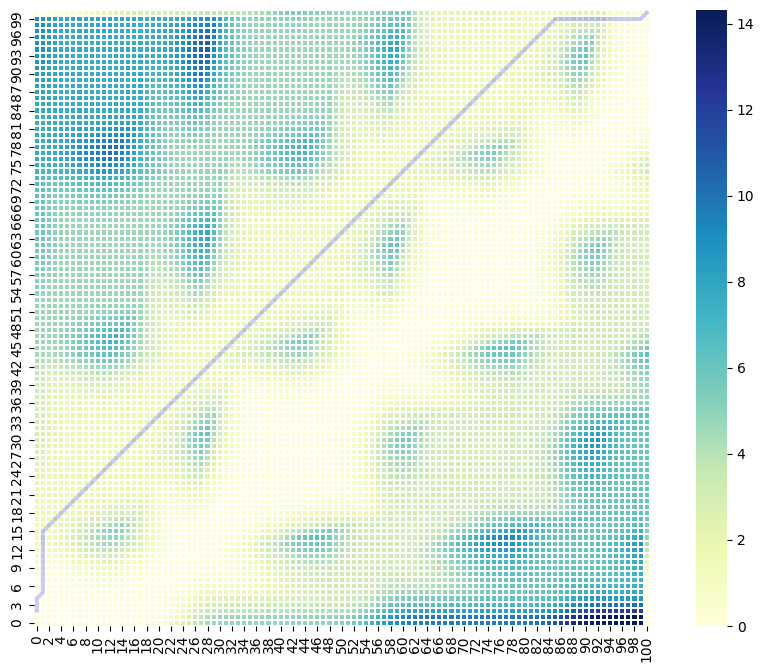

In [9]:
import seaborn as sbn
# Отрисуем матрицы весов расстояний Ts1 и Ts2

cost_matrix = s12[2]
warp_path = s12[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

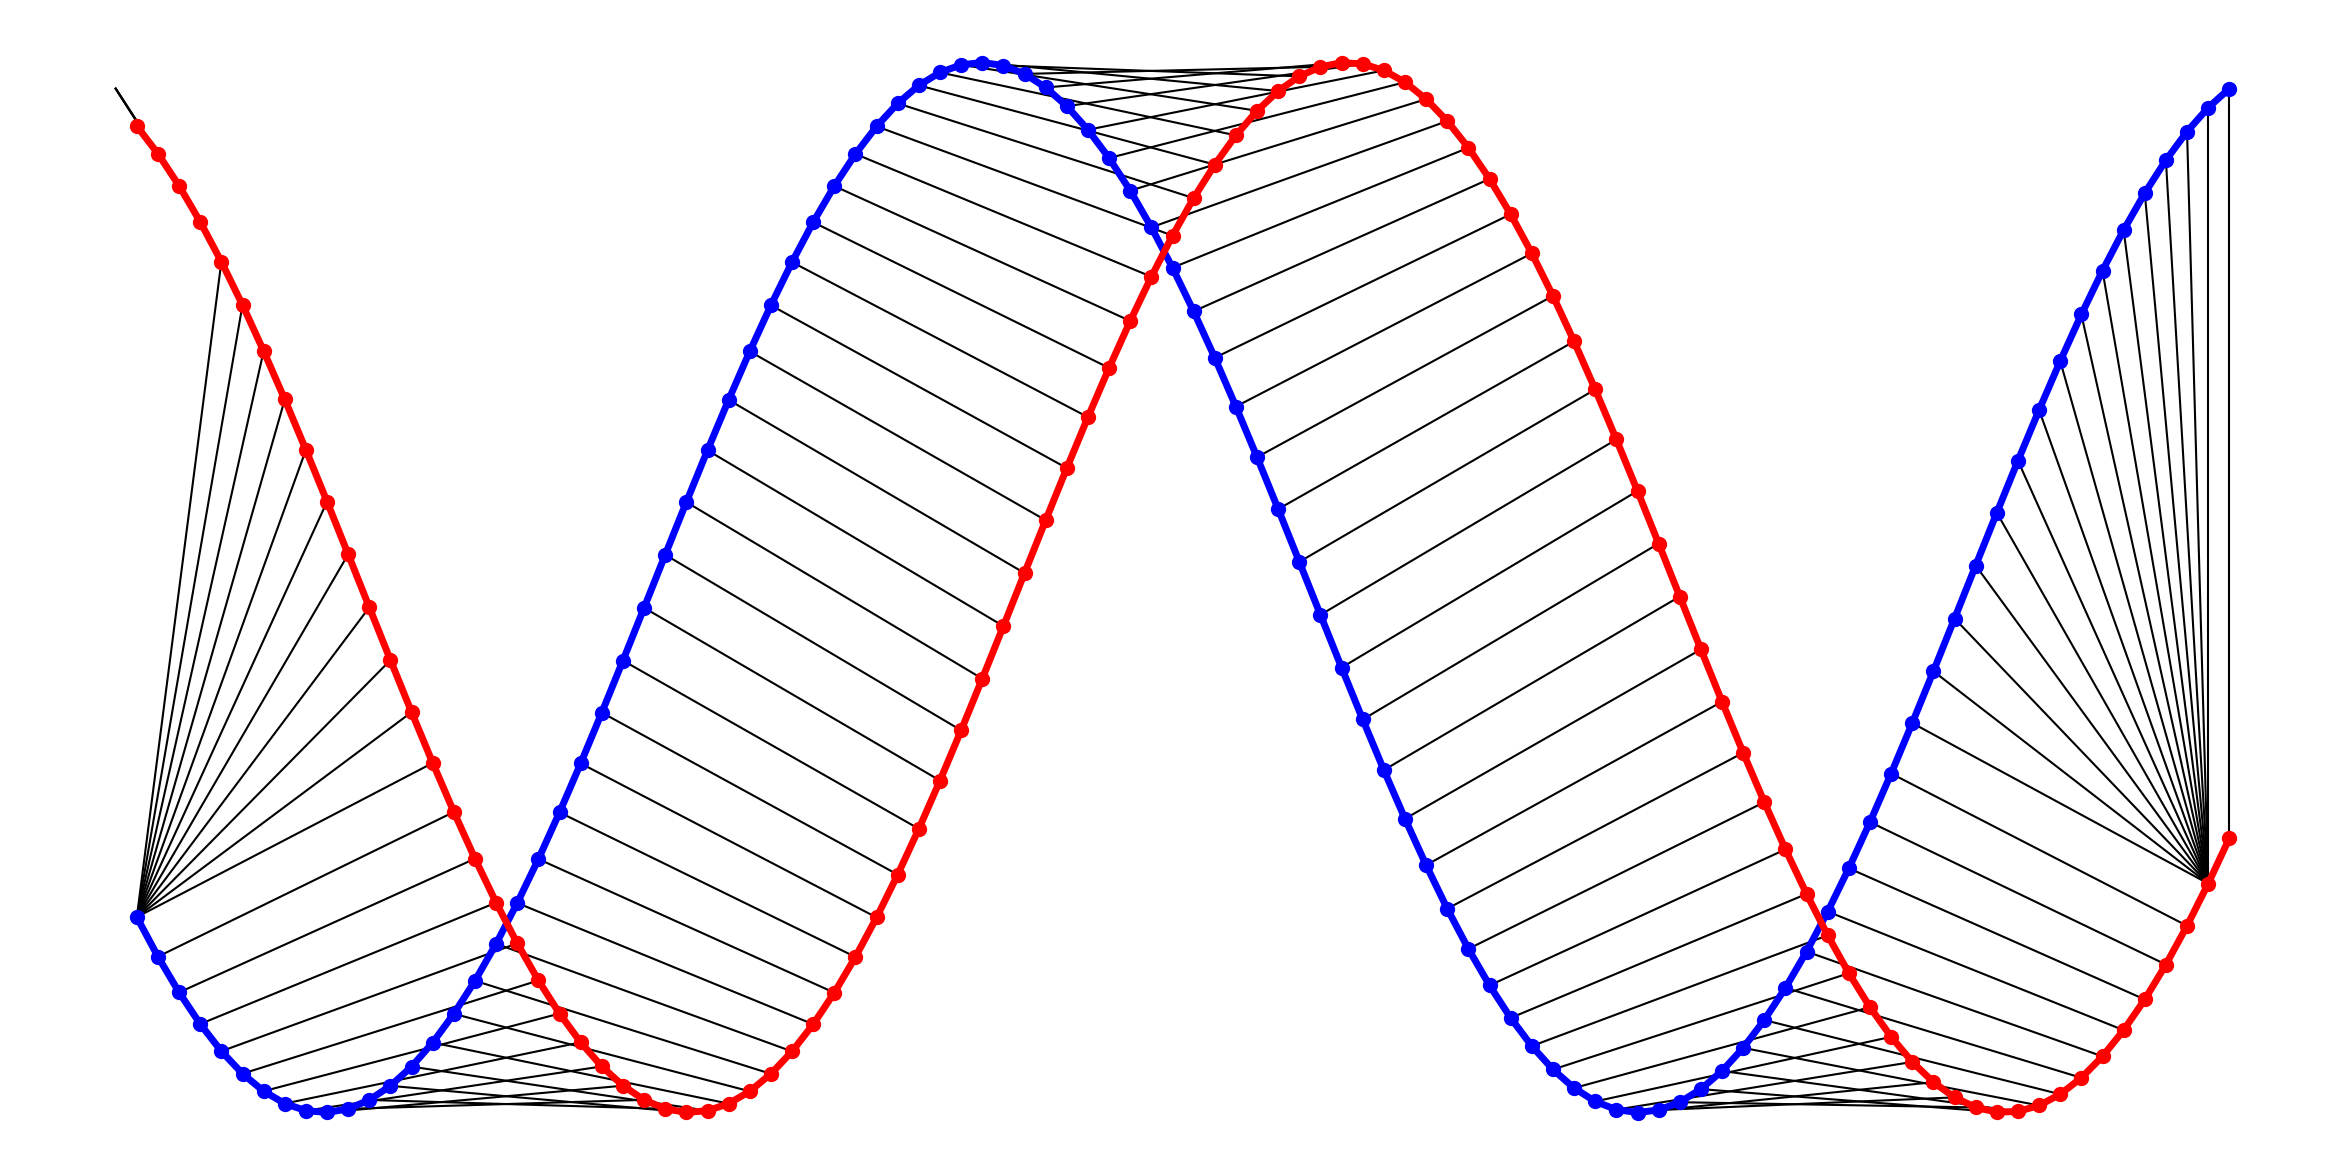

In [10]:
fig, ax = plt.subplots(figsize=(30, 15))


warp_path = s12[1]
x1 = class1[0]
x2 = class2[0]

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:   
    ax.set_facecolor('white')
    ax.plot([map_x-1, map_y-1], [x1[map_x-1], x2[map_y-1]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

DTW хорошо вычесляет расстояние между синусом и косинусом(даже со смещением)

In [11]:

X_train, y_train, X_test, y_test = [],[],[],[]
X_train = class1[:5]+class2[:5]+class3[:5]
X_test = class1[5:]+class2[5:]+class3[5:]
y_train = [0]*5+[1]*5+[2]*5
y_test = [0]*2+[1]*2+[2]*2

In [12]:
def DTW_cut(X, x_s):
    return DTW(X, x_s)[0]

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

knn_dtw = KNeighborsClassifier(metric=DTW)
knn_euclidean =KNeighborsClassifier(metric='euclidean')
tsf = RandomForestClassifier(n_estimators=100, random_state=1)

In [14]:
knn_dtw.fit(X_train, y_train)
knn_euclidean.fit(X_train, y_train)
tsf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [15]:
np.array(X_train).shape, np.array(y_train).shape, np.array(X_test).shape, np.array(y_test).shape

((15, 100), (15,), (6, 100), (6,))

In [21]:
print(f"Accuracy DTW {knn_dtw.score(X_test, y_test)}")
print(f"Accuracy Euclid {knn_euclidean.score(X_test, y_test)}")
print(f"Accuracy Forest {tsf.score(X_test, y_test)}")


Accuracy DTW 1.0
Accuracy Euclid 1.0
Accuracy Forest 1.0
